In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocess before experiments

In [2]:
df_raw = pd.read_csv("GT_trajectories_raw.csv")
print(df_raw.shape)
df_raw.head()

(623, 10)


,gt_id,shortage_event_id,ndc_id,Status,Timestamp,Reason for Shortage,Generic Name,Company Name,Initial Posting Date,Date of Update
0,5,00527-1395-11/25/2019,00527-1395,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",11/25/19,6/14/22
1,5,00527-1396-11/25/2019,00527-1396,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",11/25/19,6/14/22
2,5,00527-1397-11/25/2019,00527-1397,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",11/25/19,6/14/22
3,5,00591-0371-11/25/2019,00591-0371,resolved,8/14/23 0:01,NaN,Loxapine Capsules,Teva Pharmaceuticals,11/25/19,6/14/22
4,5,00527-1394-11/25/2019,00527-1394,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",11/25/19,6/14/22


In [3]:
df_raw.columns

Index(['gt_id', 'shortage_event_id', 'ndc_id', 'Status', 'Timestamp',
       ' Reason for Shortage', 'Generic Name', 'Company Name',
       'Initial Posting Date', 'Date of Update'],
      dtype='object')

In [4]:
df_raw['Initial Posting Date'] = pd.to_datetime(df_raw['Initial Posting Date'])
df_raw['Date of Update'] = pd.to_datetime(df_raw['Date of Update'])

df_raw['quarters_between'] = (
    df_raw['Date of Update'].dt.to_period('Q')         
    - df_raw['Initial Posting Date'].dt.to_period('Q')
).apply(lambda x: x.n)


/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_3734/94494800.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['Initial Posting Date'] = pd.to_datetime(df_raw['Initial Posting Date'])
/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_3734/94494800.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['Date of Update'] = pd.to_datetime(df_raw['Date of Update'])


In [5]:
df_raw['company_code'] = df_raw['ndc_id'].apply(lambda x: x.split("-")[0])
df_raw

,gt_id,shortage_event_id,ndc_id,Status,Timestamp,Reason for Shortage,Generic Name,Company Name,Initial Posting Date,Date of Update,quarters_between,company_code
0,5,00527-1395-11/25/2019,00527-1395,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",2019-11-25,2022-06-14,10,00527
1,5,00527-1396-11/25/2019,00527-1396,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",2019-11-25,2022-06-14,10,00527
2,5,00527-1397-11/25/2019,00527-1397,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",2019-11-25,2022-06-14,10,00527
3,5,00591-0371-11/25/2019,00591-0371,resolved,8/14/23 0:01,NaN,Loxapine Capsules,Teva Pharmaceuticals,2019-11-25,2022-06-14,10,00591
4,5,00527-1394-11/25/2019,00527-1394,to be discontinued,8/14/23 0:01,NaN,Loxapine Capsules,"Lannett Company, Inc.",2019-11-25,2022-06-14,10,00527
...,...,...,...,...,...,...,...,...,...,...,...,...
618,80,49884-0156-06/24/2021,49884-0156,resolved,8/14/23 0:01,NaN,Varenicline Tartrate (Chantix) Tablets,Par Pharmaceutical,2021-06-24,2022-05-26,4,49884
619,80,49884-0944-06/24/2021,49884-0944,resolved,8/14/23 0:01,NaN,Varenicline Tartrate (Chantix) Tablets,Par Pharmaceutical,2021-06-24,2022-05-26,4,49884
620,80,60505-4766-06/24/2021,60505-4766,resolved,8/14/23 0:01,NaN,Varenicline Tartrate (Chantix) Tablets,Apotex Corp.,2021-06-24,2022-05-26,4,60505
621,80,60505-4765-06/24/2021,60505-4765,resolved,8/14/23 0:01,NaN,Varenicline Tartrate (Chantix) Tablets,Apotex Corp.,2021-06-24,2022-05-26,4,60505


In [6]:
def summarize(group: pd.DataFrame) -> pd.Series:
    # manufacturers that have at least one “to be discontinued” row
    disc_rows     = group['Status'].eq('to be discontinued')
    disc_makers   = group.loc[disc_rows, 'Company Name'].unique()

    # --- build the usual columns ---
    n_makers      = group['Company Name'].nunique()
    gt_type       = group['Status'].nunique()
    quarters        = group['quarters_between'].iloc[0]          # first value in original order
    disruption_nr = len(disc_makers)

    # --- disruption magnitude (average percentage across those makers) ---
    if disruption_nr == 0:          # no disruptions in this gt_id
        disruption_mag = 0.2
    else:
        # proportion of “discontinued” rows for each disrupted maker
        maker_pct = (
            group[group['Company Name'].isin(disc_makers)]
            .groupby('Company Name')['Status']
            .apply(lambda s: (s == 'to be discontinued').mean())   # mean() on booleans → proportion
        )
        disruption_mag = maker_pct.mean()        # average across makers

    return pd.Series({
        'n_manufacturers'   : n_makers,
        'gt_type'           : gt_type,
        'quarters'            : quarters,
        'disruption_number' : disruption_nr,
        'disruption_magnitude': disruption_mag     # 0 – 1 proportion; multiply by 100 for %
    })

# one tidy summary table
df = df_raw.groupby('gt_id', as_index=False).apply(summarize)
df['disruption_magnitude'] = df.disruption_magnitude.apply(lambda x: 0.6 if x > 0.5 else x)
df['periods'] = df.quarters.apply(lambda x: 4 if x <4 else x)

/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_3734/2567830033.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_raw.groupby('gt_id', as_index=False).apply(summarize)


In [7]:
df.gt_type.value_counts()

gt_type
1.0    57
2.0    16
Name: count, dtype: int64

In [ ]:
# enforced disruption start
print(df.loc[(df.periods < 12) & (df.gt_type == 2)].shape)
df.loc[(df.periods < 12) & (df.gt_type == 2)].to_csv("GT_Disc.csv", index=False)

(11, 7)


In [113]:
# random disruption start
print(df.loc[(df.periods < 12) & (df.gt_type == 1)].shape)
df.loc[(df.periods < 12) & (df.gt_type == 1)].to_csv("GT_NoDisc.csv", index=False)

(41, 7)


# Evaluation

In [464]:
import ast
# gt_disc_file_name = "gt_experiments_20250730_220734.csv"
# df = pd.read_csv("../src/gt_evaluation/" + gt_disc_file_name)
# gt_nodisc_file_name = "gt_experiments_20250730_214409.csv"
# df = pd.read_csv(gt_nodisc_file_name)
zero_shot_disc = "gt_zero_shot_experiments_20250801_214120.csv"
df = pd.read_csv(zero_shot_disc)
# df['trajectory'] = df.trajectory.apply(lambda x: ast.literal_eval(x))
# zero_shot_nr = "gt_zero_shot_experiments_20250801_221227.csv"
# df = pd.read_csv(zero_shot_nr)
df['trajectory'] = df.traje.apply(lambda x: ast.literal_eval(x))

In [465]:
df.shape

(11, 20)

In [466]:
print(df.n_manufacturers.mean(),df.periods.std())

4.090909090909091 2.5298221281347035


In [467]:
df.disruption_magnitude.mean()

np.float64(0.5575757575757575)

In [468]:
print(df.periods.mean(),df.periods.std())

6.0 2.5298221281347035


In [469]:
(df.fda_interventions/df.periods).mean()

np.float64(0.9606060606060606)

In [470]:
tmp = df.explode('trajectory', ignore_index=True)
sim_cols = (
    pd.json_normalize(tmp['trajectory'])  # dict → columns
      .rename(lambda c: f"trajectory_{c}", axis=1)  # optional: prefix to avoid clashes
)
final_df = (
    tmp.drop(columns='trajectory')   # keep every other column once
       .reset_index(drop=True)        # tidy up the index after explode
       .join(sim_cols)                # add the flattened columns
)

In [471]:
final_df['shortage_flag'] = final_df.apply(lambda x: x.trajectory_total_supply - 1 <= -0.001, axis=1)
# final_df['shortage_flag'] = final_df.apply(lambda x: x.trajectory_total_supply - 1 < 0, axis=1)

# final_df.to_csv("GT_Disc_zeroshot.csv")
# final_df.to_csv("GT_NR_trajectories.csv")
# final_df.to_csv("GT_Disc_trajectories.csv")

In [472]:
cols_to_sort = ['scenario', 'trajectory_period']
df_sorted = final_df.sort_values(cols_to_sort)

# get the last row for every (scenario, simulation) combo
final_flag = (
    df_sorted
      .groupby(['scenario'])
      .tail(1)['shortage_flag']
)

# resolution success (=1 if shortage_actual == False)
resolved = (~final_flag).astype(int)

resolution_success_rate = resolved.mean()
print(f"Resolution Success Rate: {resolution_success_rate:.2%}")

Resolution Success Rate: 90.91%


In [473]:
import pandas as pd
import numpy as np

###############################################################################
# 0.  Columns expected in df_sim
#     ------------------------------------------------------
#     scenario         ← GT case ID  (str / int)
#     simulation_id    ← run ID      (drop if single run)
#     period           ← 0 … T
#     shortage_amount  ← numeric shortage;  or use your Boolean flag directly
###############################################################################

# THRESH = 1e-6                                        # ε tolerance
# df_sim["shortage_flag"] = df_sim["shortage_amount"] > THRESH
# df_sim = df_sorted

###############################################################################
# 1.  Earliest *sustained* clearance in each run
###############################################################################
def earliest_sustained_clear(group: pd.DataFrame) -> int:
    """Return t_sim for one (scenario) group."""
    g = group.sort_values("trajectory_period").reset_index(drop=True)

    # True if any shortage occurs *after* the current period
    future_shortage = (
        g["shortage_flag"].shift(-1, fill_value=False)[::-1]
          .cummax()[::-1]
    )

    candidates = g[(~g["shortage_flag"]) & (~future_shortage)]

    if not candidates.empty:                          # clearance is permanent
        return int(candidates["trajectory_period"].iloc[0])
    else:                                             # never fully clears
        return int(g["trajectory_period"].max() + 1)

t_sim = (
    df_sorted.groupby(["scenario"], sort=False)
          .apply(earliest_sustained_clear)
          .rename("t_sim")
)

###############################################################################
# 2.  Ground-truth resolution time  (trajectory ends when cleared)
###############################################################################
t_gt = (
    df_sorted.groupby('scenario')['trajectory_period']
         .max()
         .rename('t_gt')
)

###############################################################################
# 3.  Assemble  →  lag  →  RLP
###############################################################################
horizon = (
    df_sorted.groupby(["scenario"])["trajectory_period"]
          .max()
          .rename("T")
)

meta = (
    t_sim.to_frame()
         .join(horizon, how="left")          # adds T
         .reset_index()
         .merge(t_gt.reset_index(), on="scenario", how="left")
)

# t_sim already has T+1 for unresolved runs, so no extra fill needed
meta['t_sim'] = meta['t_sim'] + 1
meta['t_gt'] = meta['t_gt'] + 1
meta['T'] = meta['T']+1

meta["lag"] = meta["t_sim"] - meta["t_gt"]
meta["rlp"] = 100 * meta["lag"] / meta["t_gt"]

###############################################################################
# 4.  Aggregate (optional)
###############################################################################
overall_mean_rlp = meta["rlp"].mean()
rlp_summary      = meta.groupby("scenario")["rlp"].agg(["mean", "median", "std"])

print("Mean RLP across runs: {:.2f}%".format(overall_mean_rlp))
print(meta["rlp"].std())

Mean RLP across runs: -8.42%
13.26781210967714


/var/folders/33/gyvvd4710r7_4n22mnftfz4h0000gn/T/ipykernel_3734/2999701862.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(earliest_sustained_clear)


In [463]:
((np.abs(meta.t_sim - meta.t_gt))**2).sum()/meta.shape[0]

np.float64(7.512195121951219)

In [375]:
df_sorted.loc[df_sorted.scenario == "gt_id_54"]

,scenario,simulation_id,#simulation,gt_type,n_manufacturers,periods,disruption_prob,disruption_magnitude,traje,peak_shortage,...,method,trajectory_period,trajectory_total_demand,trajectory_total_supply,trajectory_shortage_amount,trajectory_unsold,trajectory_shortage_percentage,trajectory_disrupted_manufacturers,trajectory_fda_announcement,shortage_flag
28,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,0,1.00,0.70,0.30,0.0,30.00,[],Initial shortage observed. Monitoring closely.,True
29,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,1,1.10,0.70,0.40,0.0,36.36,[],Encouraging manufacturers to increase production.,True
30,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,2,1.15,0.70,0.45,0.0,39.13,[],FDA may expedite approvals for capacity expans...,True
31,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,3,1.10,0.85,0.25,0.0,22.73,[],First signs of supply increase observed.,True
32,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,4,1.05,0.95,0.10,0.0,9.52,[],"Supply improving, shortage reducing.",True
33,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,5,1.00,1.00,0.00,0.0,0.00,[],Shortage resolved. Monitoring for stability.,False
34,gt_id_54,16699a13,0,2.0,2,7,0.05,0.6,"[{'period': 0, 'total_demand': 1.0, 'total_sup...",0.3913,...,zero_shot_trajectory,6,1.00,1.00,0.00,0.0,0.00,[],Market stable. No further interventions planned.,False


In [303]:
sim_df = df_sorted.copy(deep=True)
sim_df.head()

,scenario,simulation_id,#simulation,gt_type,n_manufacturers,periods,disruption_prob,disruption_magnitude,peak_shortage,avg_shortage,...,fda_interventions,trajectory_period,trajectory_total_demand,trajectory_total_supply,trajectory_shortage_amount,trajectory_unsold,trajectory_shortage_percentage,trajectory_disrupted_manufacturers,trajectory_fda_announcement,shortage_flag
190,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.3,0.128745,...,6,0,1.0,1.0000,0.0000,0.0000,0.000000,[],None,False
191,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.3,0.128745,...,6,1,1.2,0.9600,0.2400,0.0000,0.200000,[0],The FDA is monitoring the emerging drug shorta...,True
192,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.3,0.128745,...,6,2,1.5,1.0500,0.4500,0.0500,0.300000,[0],The FDA is currently aware of supply disruptio...,False
193,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.3,0.128745,...,6,3,1.5,1.1835,0.3165,0.1835,0.211000,[0],The FDA acknowledges an emerging shortage of a...,False
194,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.3,0.128745,...,6,4,1.4,1.2445,0.1555,0.2445,0.111071,[],None,False


In [304]:
sim_df.columns

Index(['scenario', 'simulation_id', '#simulation', 'gt_type',
       'n_manufacturers', 'periods', 'disruption_prob', 'disruption_magnitude',
       'peak_shortage', 'avg_shortage', 'shortage_periods', 'resolution_time',
       'total_profit', 'buyer_cost', 'fda_interventions', 'trajectory_period',
       'trajectory_total_demand', 'trajectory_total_supply',
       'trajectory_shortage_amount', 'trajectory_unsold',
       'trajectory_shortage_percentage', 'trajectory_disrupted_manufacturers',
       'trajectory_fda_announcement', 'shortage_flag'],
      dtype='object')

In [306]:
meta.loc[meta["scenario"] == "gt_id_19", "t_gt"].iloc[0]

np.int64(5)

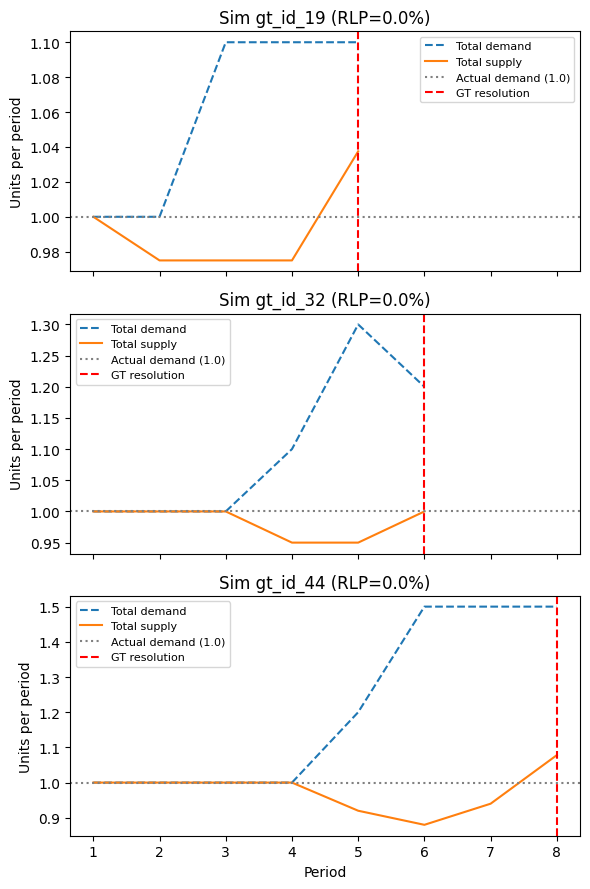

In [309]:
best_examples = ["gt_id_19", "gt_id_32", "gt_id_44"]
fig, axes = plt.subplots(len(best_examples), 1, figsize=(6, 3 * len(best_examples)), sharex=True)

for ax, sim_id in zip(axes, best_examples):
    df = sim_df[sim_df["scenario"] == sim_id].sort_values("trajectory_period")
    ax.plot(df["trajectory_period"]+1, df["trajectory_total_demand"], "--", label="Total demand")
    ax.plot(df["trajectory_period"]+1, df["trajectory_total_supply"], "-", label="Total supply")
    ax.axhline(1.0, color="gray", linestyle=":", label="Actual demand (1.0)")
    gt = meta.loc[meta["scenario"] == sim_id, "t_gt"].iloc[0]
    ax.axvline(gt, color="red", linestyle="--", label="GT resolution")
    rlp = meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]
    ax.set_title(f"Sim {sim_id} (RLP={rlp:.1f}%)")
    ax.set_ylabel("Units per period")
    ax.legend(fontsize=8)

axes[-1].set_xlabel("Period")
plt.tight_layout()
plt.show()

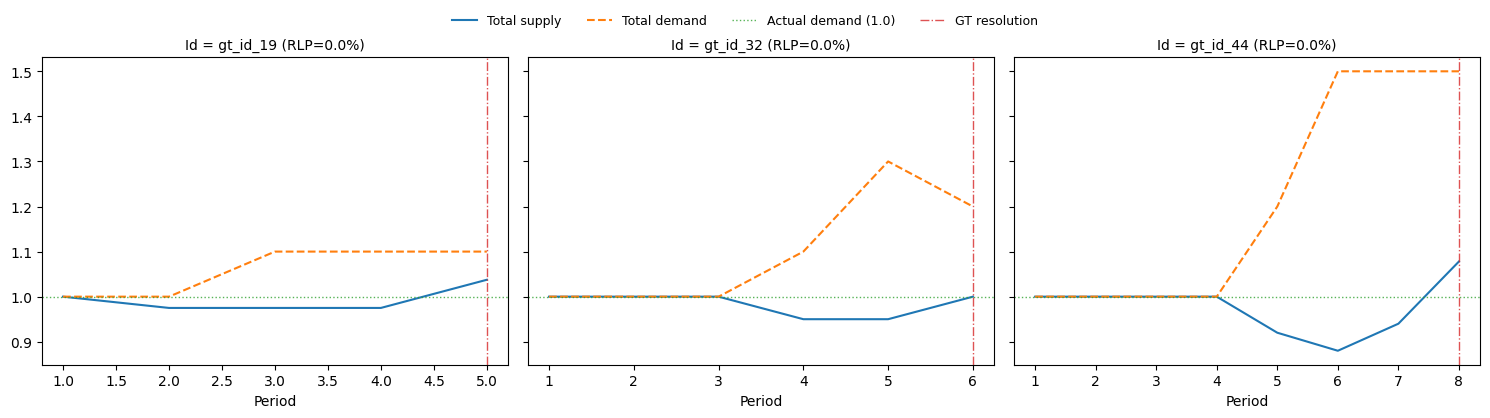

In [322]:
# List of scenarios to plot
best_examples = ["gt_id_19", "gt_id_32", "gt_id_44"]

# Grab the default color cycle
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
supply_color = cycle[0]    # blue-ish
demand_color = cycle[1]    # orange-ish
actual_color = cycle[2]    # green-ish
gt_color     = cycle[3]    # red-ish

# Create a 1×N horizontal subplot layout
fig, axes = plt.subplots(1, len(best_examples), 
                         figsize=(5 * len(best_examples), 4), 
                         sharey=True)

for ax, sim_id in zip(axes, best_examples):
    # Extract data
    df = sim_df[sim_df["scenario"] == sim_id].sort_values("trajectory_period")
    gt  = meta.loc[meta["scenario"] == sim_id, "t_gt"].iloc[0]
    rlp = meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]
    
    # Plot with softer/default palette
    ax.plot(df["trajectory_period"] + 1,
            df["trajectory_total_supply"],
            linestyle='-',
            linewidth=1.5,
            label='Total supply',
            color=supply_color)
    
    ax.plot(df["trajectory_period"] + 1,
            df["trajectory_total_demand"],
            linestyle='--',
            linewidth=1.5,
            label='Total demand',
            color=demand_color)
    
    # Horizontal & vertical reference lines
    ax.axhline(1.0,
               linestyle=':',
               linewidth=1,
               label='Actual demand (1.0)',
               color=actual_color,
               alpha=0.8)
    
    ax.axvline(gt,
               linestyle='-.',
               linewidth=1,
               label='GT resolution',
               color=gt_color,
               alpha=0.8)
    
    # Titles & labels
    ax.set_title(f"Id = {sim_id} (RLP={rlp:.1f}%)", fontsize=10)
    ax.set_xlabel("Period", fontsize=10)

# Shared legend, nudged above the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),  # x=0.5 center, y=1.15 above the top
    ncol=4,
    frameon=False,
    fontsize=9
)

# Give more room at the top so the legend doesn’t overlap
fig.subplots_adjust(top=0.15, wspace=0.3)

plt.tight_layout()
plt.show()

19
17
22


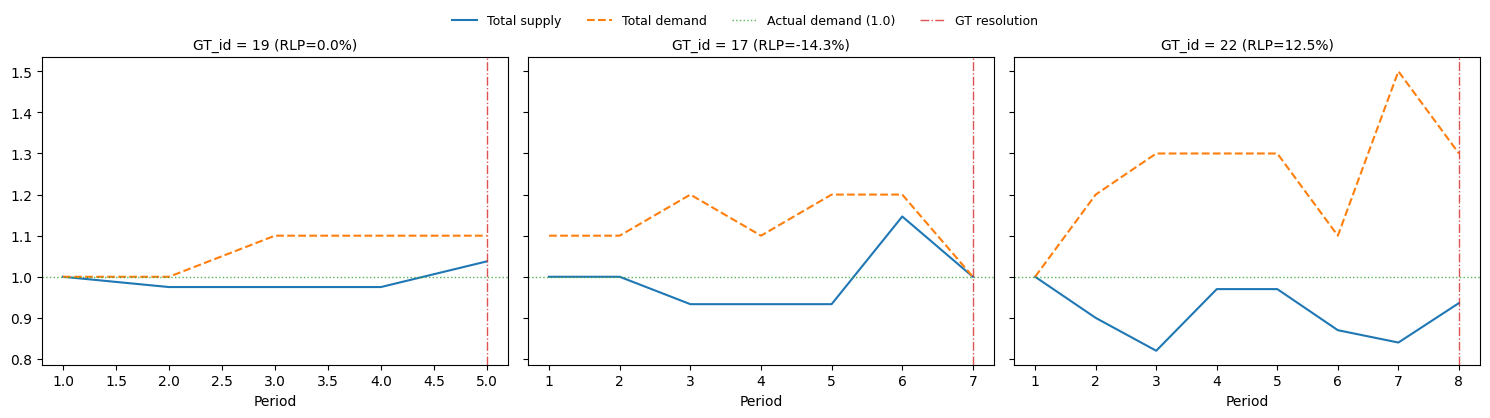

In [335]:
# List of scenarios to plot
best_examples = ["gt_id_19", "gt_id_17", "gt_id_22"]

# Grab the default color cycle
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
supply_color = cycle[0]    # blue-ish
demand_color = cycle[1]    # orange-ish
actual_color = cycle[2]    # green-ish
gt_color     = cycle[3]    # red-ish

# Create a 1×N horizontal subplot layout
fig, axes = plt.subplots(1, len(best_examples), 
                         figsize=(5 * len(best_examples), 4), 
                         sharey=True)

for ax, sim_id in zip(axes, best_examples):
    # Extract data
    df = sim_df[sim_df["scenario"] == sim_id].sort_values("trajectory_period")
    gt  = meta.loc[meta["scenario"] == sim_id, "t_gt"].iloc[0]
    rlp = meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]
    
    # Plot with softer/default palette
    ax.plot(df["trajectory_period"] + 1,
            df["trajectory_total_supply"],
            linestyle='-',
            linewidth=1.5,
            label='Total supply',
            color=supply_color)
    
    ax.plot(df["trajectory_period"] + 1,
            df["trajectory_total_demand"],
            linestyle='--',
            linewidth=1.5,
            label='Total demand',
            color=demand_color)
    
    # Horizontal & vertical reference lines
    ax.axhline(1.0,
               linestyle=':',
               linewidth=1,
               label='Actual demand (1.0)',
               color=actual_color,
               alpha=0.8)
    
    ax.axvline(gt,
               linestyle='-.',
               linewidth=1,
               label='GT resolution',
               color=gt_color,
               alpha=0.8)
    
    # Titles & labels
    print(sim_id.split("_")[-1])
    ax.set_title(f"GT_id = {sim_id.split('_')[-1]} (RLP={rlp:.1f}%)", fontsize=10)
    ax.set_xlabel("Period", fontsize=10)

# Shared legend, nudged above the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),  # x=0.5 center, y=1.15 above the top
    ncol=4,
    frameon=False,
    fontsize=9
)

# Give more room at the top so the legend doesn’t overlap
fig.subplots_adjust(top=0.15, wspace=0.3)

plt.tight_layout()
plt.show()

In [ ]:
sim_df.trajectory_fda_announcement

,scenario,simulation_id,#simulation,gt_type,n_manufacturers,periods,disruption_prob,disruption_magnitude,peak_shortage,avg_shortage,...,fda_interventions,trajectory_period,trajectory_total_demand,trajectory_total_supply,trajectory_shortage_amount,trajectory_unsold,trajectory_shortage_percentage,trajectory_disrupted_manufacturers,trajectory_fda_announcement,shortage_flag
190,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.30,0.128745,...,6,0,1.0,1.0000,0.0000,0.0000,0.000000,[],None,False
191,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.30,0.128745,...,6,1,1.2,0.9600,0.2400,0.0000,0.200000,[0],The FDA is monitoring the emerging drug shorta...,True
192,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.30,0.128745,...,6,2,1.5,1.0500,0.4500,0.0500,0.300000,[0],The FDA is currently aware of supply disruptio...,False
193,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.30,0.128745,...,6,3,1.5,1.1835,0.3165,0.1835,0.211000,[0],The FDA acknowledges an emerging shortage of a...,False
194,gt_id_11,b5957c62,0,1,5,8,0.05,0.2,0.30,0.128745,...,6,4,1.4,1.2445,0.1555,0.2445,0.111071,[],None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,gt_id_78,e3fd7a50,0,1,2,4,0.05,0.2,0.25,0.139205,...,2,3,1.2,1.0500,0.1500,0.0500,0.125000,[1],The FDA is monitoring an emerging drug shortag...,False
186,gt_id_80,8861ffd4,0,1,3,4,0.05,0.2,0.00,0.000000,...,0,0,1.0,1.0000,0.0000,0.0000,0.000000,[],None,False
187,gt_id_80,8861ffd4,0,1,3,4,0.05,0.2,0.00,0.000000,...,0,1,1.0,1.0000,0.0000,0.0000,0.000000,[],None,False
188,gt_id_80,8861ffd4,0,1,3,4,0.05,0.2,0.00,0.000000,...,0,2,1.0,1.0000,0.0000,0.0000,0.000000,[],None,False


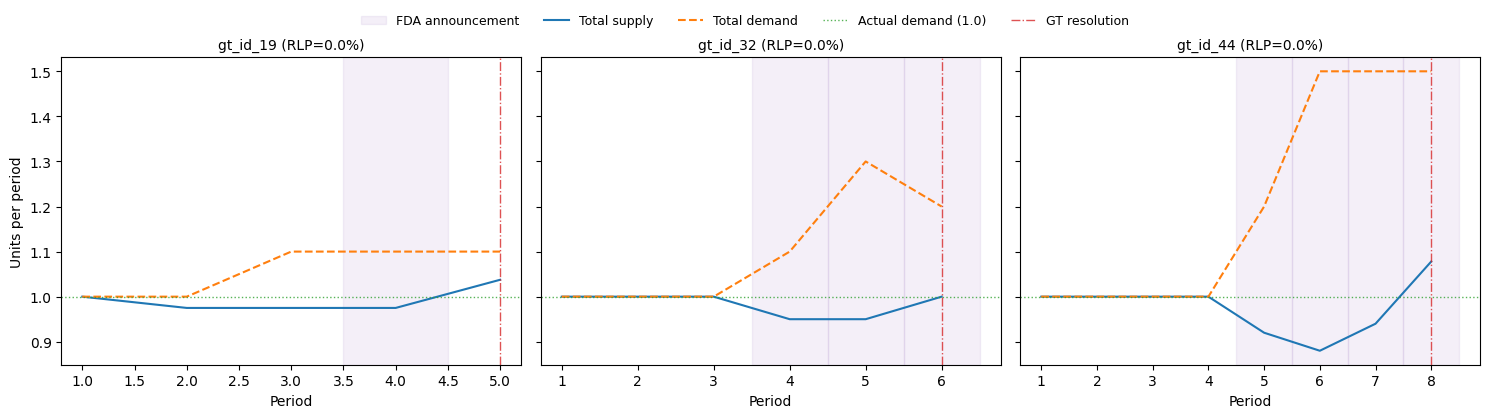

In [ ]:
from matplotlib import rcParams

# 1) Set global, publication‐style font settings
rcParams['font.family']       = 'serif'
rcParams['font.size']         = 12
rcParams['axes.titlesize']    = 14
rcParams['axes.labelsize']    = 12
rcParams['xtick.labelsize']   = 11
rcParams['ytick.labelsize']   = 11
rcParams['legend.fontsize']   = 12


# Scenarios to plot
best_examples = ["gt_id_19", "gt_id_32", "gt_id_44"]

# Use default color cycle for consistency
cycle       = plt.rcParams['axes.prop_cycle'].by_key()['color']
supply_color= cycle[0]
demand_color= cycle[1]
actual_color= cycle[2]
gt_color    = cycle[3]
ann_color   = cycle[4] if len(cycle) > 4 else 'purple'

# Create a 1×N horizontal layout
fig, axes = plt.subplots(
    1, len(best_examples),
    figsize=(5 * len(best_examples), 4),
    sharey=True
)

for ax, sim_id in zip(axes, best_examples):
    # Extract and sort
    df  = sim_df[sim_df["scenario"] == sim_id].sort_values("trajectory_period")
    gt  = meta.loc[meta["scenario"] == sim_id, "t_gt"].iloc[0]
    rlp = meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]

    # Shade FDA announcement periods
    ann_periods = (
        df.loc[df["trajectory_fda_announcement"].notna(), "trajectory_period"] + 1
    )
    first = True
    for p in ann_periods:
        ax.axvspan(
            p - 0.5, p + 0.5,
            color=ann_color,
            alpha=0.1,
            label="FDA announcement" if first else None
        )
        first = False

    # Plot supply & demand
    ax.plot(
        df["trajectory_period"] + 1,
        df["trajectory_total_supply"],
        "-", linewidth=1.5,
        label="Total supply", color=supply_color
    )
    ax.plot(
        df["trajectory_period"] + 1,
        df["trajectory_total_demand"],
        "--", linewidth=1.5,
        label="Total demand", color=demand_color
    )

    # Reference lines
    ax.axhline(
        1.0, linestyle=":", linewidth=1,
        label="Actual demand (1.0)", color=actual_color, alpha=0.8
    )
    ax.axvline(
        gt, linestyle="-.", linewidth=1,
        label="GT resolution", color=gt_color, alpha=0.8
    )

    ax.set_title(f"{sim_id} (RLP={rlp:.1f}%)", fontsize=10)
    ax.set_xlabel("Period", fontsize=10)

# One shared legend, moved above
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=5,
    frameon=False,
    fontsize=9
)

# Y-axis label on first subplot
axes[0].set_ylabel("Units per period", fontsize=10)

# Adjust spacing for legend and subplots
fig.subplots_adjust(top=0.75, wspace=0.3)
plt.tight_layout()
plt.show()


In [ ]:
meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]

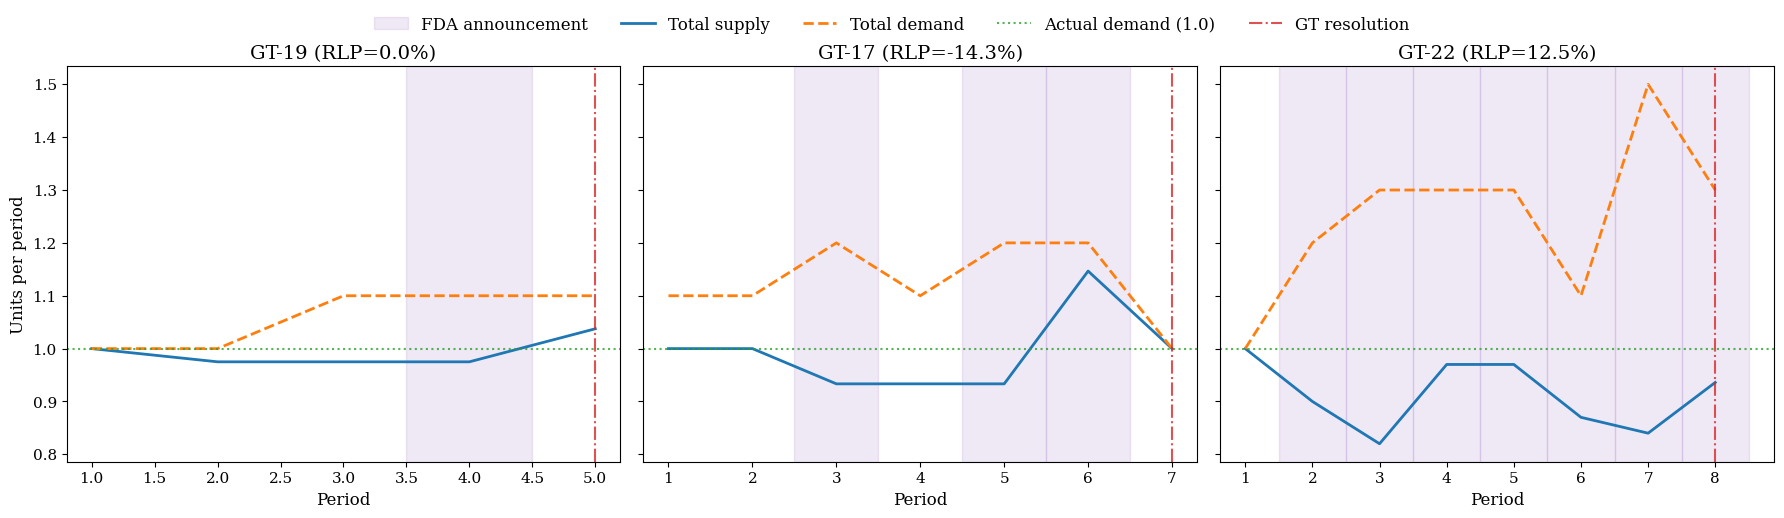

In [341]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 1) Set global, publication‐style font settings
rcParams['font.family']       = 'serif'
rcParams['font.size']         = 12
rcParams['axes.titlesize']    = 14
rcParams['axes.labelsize']    = 12
rcParams['xtick.labelsize']   = 11
rcParams['ytick.labelsize']   = 11
rcParams['legend.fontsize']   = 12

# 2) Scenarios to plot
best_examples = ["gt_id_19", "gt_id_17", "gt_id_22"]

# 3) Grab default color cycle
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
supply_color  = cycle[0]
demand_color  = cycle[1]
actual_color  = cycle[2]
gt_color      = cycle[3]
ann_color     = cycle[4] if len(cycle) > 4 else 'purple'

# 4) Create 1×N horizontal layout with larger figure size
fig, axes = plt.subplots(
    1, len(best_examples),
    figsize=(6 * len(best_examples), 5),
    sharey=True
)

for ax, sim_id in zip(axes, best_examples):
    # Extract and sort data
    df  = sim_df[sim_df["scenario"] == sim_id].sort_values("trajectory_period")
    gt  = meta.loc[meta["scenario"] == sim_id, "t_gt"].iloc[0]
    rlp = meta.loc[meta["scenario"] == sim_id, "rlp"].iloc[0]

    # Shade FDA announcement periods
    ann_periods = (df.loc[df["trajectory_fda_announcement"].notna(), "trajectory_period"] + 1)
    first = True
    for p in ann_periods:
        ax.axvspan(
            p - 0.5, p + 0.5,
            color=ann_color,
            alpha=0.15,
            label="FDA announcement" if first else None
        )
        first = False

    # Plot supply & demand with clear linestyles
    ax.plot(
        df["trajectory_period"] + 1,
        df["trajectory_total_supply"],
        linestyle='-',
        linewidth=2,
        label='Total supply',
        color=supply_color
    )
    ax.plot(
        df["trajectory_period"] + 1,
        df["trajectory_total_demand"],
        linestyle='--',
        linewidth=2,
        label='Total demand',
        color=demand_color
    )

    # Reference lines
    ax.axhline(
        1.0, linestyle=":", linewidth=1.5,
        label='Actual demand (1.0)',
        color=actual_color,
        alpha=0.8
    )
    ax.axvline(
        gt, linestyle="-.", linewidth=1.5,
        label='GT resolution',
        color=gt_color,
        alpha=0.8
    )

    # Titles & labels
    ax.set_title(f"GT-{sim_id.split('_')[-1]} (RLP={rlp:.1f}%)")
    ax.set_xlabel("Period")

# Single shared legend, moved above with spacing
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=5,
    frameon=False
)

# Y‐axis label on first subplot
axes[0].set_ylabel("Units per period")

# Adjust spacing for legend and subplots
fig.subplots_adjust(top=0.80, wspace=0.4)
plt.tight_layout()
plt.show()